In [121]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [122]:
import os
import numpy as np
from collections import OrderedDict as OD
import math
import uproot3
import hist
import matplotlib.pyplot as plt
import mplhep as hep

#sIpFile = '/eos/cms/store/user/ssawant/htoaa/analysis/20230811_TopPtRewgt/2018/analyze_htoaa_stage1.root'
#sOpDir  = '/eos/cms/store/user/ssawant/htoaa/analysis/20230811_TopPtRewgt/2018/plots'
sIpFile = '/eos/cms/store/user/ssawant/htoaa/analysis/20230831_SelPNetMDXbbNSV/2018/analyze_htoaa_stage1.root'
sOpDir  = '/eos/cms/store/user/ssawant/htoaa/analysis/20230831_SelPNetMDXbbNSV/2018/plots'



if not os.path.exists(sOpDir):
    os.makedirs(sOpDir)
    
fIpFile = uproot3.open(sIpFile)

In [123]:
fIpFile['evt/SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150'].keys()

[b'hPV_npvs_beforeSel_central;1',
 b'hPV_npvsGood_beforeSel_central;1',
 b'hGenLHE_HT_all_central;1',
 b'hGenLHE_HTIncoming_all_central;1',
 b'hGenLHE_Vpt_all_central;1',
 b'hGenLHE_AlphaS_all_central;1',
 b'hGenLHE_Njets_all_central;1',
 b'hGenLHE_Nb_all_central;1',
 b'hGenLHE_Nc_all_central;1',
 b'hGenLHE_Nuds_all_central;1',
 b'hGenLHE_Nglu_all_central;1',
 b'hGenLHE_NpNLO_all_central;1',
 b'hGenLHE_NpLO_all_central;1',
 b'hPileup_nTrueInt_central;1',
 b'hPileup_nPU_central;1',
 b'hGenHiggsPt_all_central;1',
 b'hGenHiggsPt_GenHToAATo4B_central;1',
 b'hGenHiggsPt_sel_central;1',
 b'hGenHiggsPt_sel_wGenCuts_central;1',
 b'hGenHiggsMass_all_0_central;1',
 b'hMass_GenA_all_0_central;1',
 b'hGenHiggsMass_all_central;1',
 b'hMass_GenA_all_central;1',
 b'hMass_GenAApair_all_central;1',
 b'hMass_GenAToBBbarpair_all_central;1',
 b'hMass_Gen4BFromHToAA_all_central;1',
 b'hMass_GenAToBBbarpair_all_1_central;1',
 b'hMass_Gen4BFromHToAA_all_1_central;1',
 b'hDeltaR_GenH_GenB_max_central;1',
 b'h

In [124]:
#h = fIpFile['evt/SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150/hLeadingFatJetMass_central']

In [125]:
fIpFile['evt'].keys()

[b'Data;1',
 b'QCD;1',
 b'QCD_0bCat;1',
 b'QCD_1bCat;1',
 b'QCD_2bCat;1',
 b'QCD_3bCat;1',
 b'QCD_4bCat;1',
 b'QCD_5bAndMoreCat;1',
 b'TTToHadronic_powheg;1',
 b'TTToSemiLeptonic_powheg;1',
 b'TTTo2L2Nu_powheg;1',
 b'ZJetsToQQ_HT;1',
 b'WJetsToQQ_HT;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-12_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-12_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-15_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-15_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-20_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-25_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-25_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-30_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-30_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-35_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-35_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-40_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-40_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-45_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-45_HPtAbv150;1',
 b

In [126]:
fIpFile['evt/Data'].keys()

[b'hPV_npvs_beforeSel_noweight;1',
 b'hPV_npvsGood_beforeSel_noweight;1',
 b'hCutFlow_SR_noweight;1',
 b'hCutFlowWeighted_SR_noweight;1',
 b'hPV_npvs_SR_noweight;1',
 b'hPV_npvsGood_SR_noweight;1',
 b'nSelFatJet_SR_noweight;1',
 b'hLeadingFatJetPt_SR_noweight;1',
 b'hLeadingFatJetEta_SR_noweight;1',
 b'hLeadingFatJetPhi_SR_noweight;1',
 b'hLeadingFatJetMass_SR_noweight;1',
 b'hLeadingFatJetMSoftDrop_SR_noweight;1',
 b'hLeadingFatJetId_SR_noweight;1',
 b'hLeadingFatJetBtagDeepB_SR_noweight;1',
 b'hLeadingFatJetBtagDDBvLV2_SR_noweight;1',
 b'hLeadingFatJetBtagDDCvBV2_SR_noweight;1',
 b'hLeadingFatJetBtagHbb_SR_noweight;1',
 b'hLeadingFatJetDeepTagMD_H4qvsQCD_SR_noweight;1',
 b'hLeadingFatJetDeepTagMD_HbbvsQCD_SR_noweight;1',
 b'hLeadingFatJetDeepTagMD_ZHbbvsQCD_SR_noweight;1',
 b'hLeadingFatJetDeepTagMD_ZHccvsQCD_SR_noweight;1',
 b'hLeadingFatJetDeepTagMD_ZbbvsQCD_SR_noweight;1',
 b'hLeadingFatJetDeepTagMD_ZvsQCD_SR_noweight;1',
 b'hLeadingFatJetDeepTagMD_bbvsLight_SR_noweight;1',
 b'hLe

In [127]:
def getNonZeroMin(arr):
    return np.min( arr[np.nonzero(arr)] )



 histo_name_toUse = 'hLeadingFatJetPt_SR', systematic = 'central', yAxisScale = 'linearY', 
sBkg_list: ['QCD_0bCat', 'QCD_1bCat'] 
hBkg_integral_list (total 58608.63184708827): [33972.0595505429, 24636.572296545368] 
sBkg_list sorted by integral: [('QCD_0bCat', 33972.0595505429), ('QCD_1bCat', 24636.572296545368)]
sStack_list: ['QCD_0bCat', 'QCD_1bCat']
hBkgTot_values sum: 58608.63184708831


IndexError: list index out of range

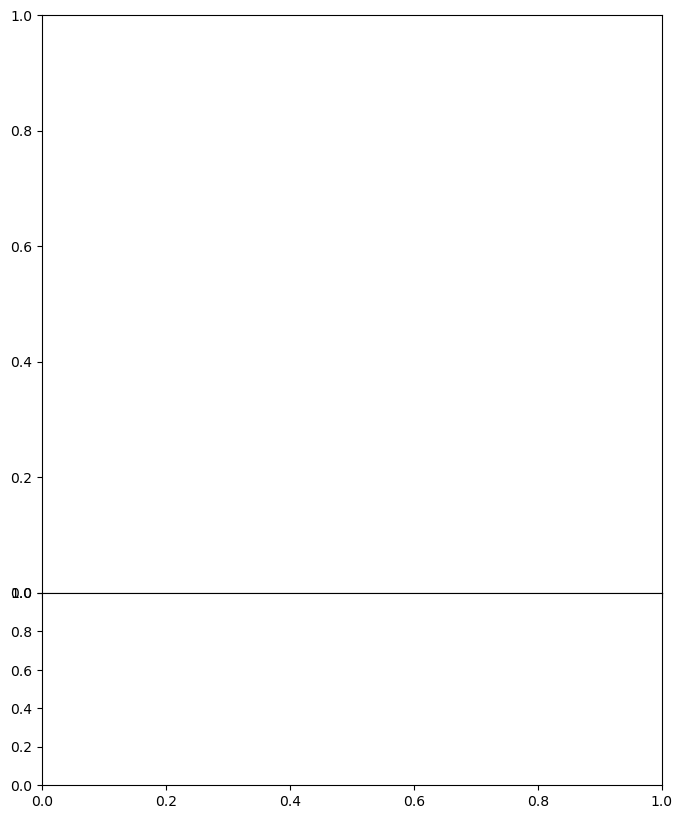

In [128]:
sXRange = "xAxisRange"; sYRange = "yAxisRange";
sXLabel = 'xAxisLabel'; sYLabel = 'yAxisLabel';

era = 2018
luminosity = 54.54  #59.83
cmsWorkStatus='Work in Progress'

sData = '' # "Data"
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_NLO', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_HT', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_Incl', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_0bCat', 'QCD_1bCat', 'QCD_2bCat', 'QCD_3bCat', 'QCD_4bCat', 'QCD_5bAndMoreCat',  'TTJets_NLO', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
MCBkg_list = ['QCD_0bCat', 'QCD_1bCat', 'QCD_2bCat', 'QCD_3bCat', 'QCD_4bCat', 'QCD_5bAndMoreCat',  'TTToHadronic_powheg', 'TTToSemiLeptonic_powheg', 'TTTo2L2Nu_powheg', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_0bCat', 'QCD_1bCat']
MCSig_list = ['SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150']
sLableSig = 'HToAATo4B_M-20'
systematics_list = ['central']
systematics_forData = 'noweight'
selectionTags = ['SR'] #['sel_leadingFatJetMSoftDrop']

scale_MCSig = 50 #1000


histograms_dict = OD([
    #("hLeadingFatJetMass", {sXLabel: 'Leading FatJet mass [GeV]', sYLabel: 'Events', sXRange: [50, 250], sYRange: [1e-2, 1e8]})
    #("hLeadingFatJetMass", {sXLabel: 'Leading FatJet mass [GeV]', sYLabel: 'Events', sXRange: [50, 250]}),
    
    #("", {sXLabel: '', sYLabel: 'Events', sXRange: []}),
    
    #("hCutFlow", {sXLabel: 'hCutFlow', sYLabel: 'Events'}),
    #("hCutFlowWeighted", {sXLabel: 'hCutFlowWeighted', sYLabel: 'Events'}),

    #("hPV_npvs_beforeSel", {sXLabel: 'No. of primary vertices before selection', sYLabel: 'Events', sXRange: [0, 100] }),
    #("hPV_npvsGood_beforeSel", {sXLabel: 'No. of good primary vertices before selection', sYLabel: 'Events', sXRange: [0, 100] }),
    #("hPV_npvs_SR", {sXLabel: 'No. of primary vertices in SR', sYLabel: 'Events', sXRange: [0, 100] }),
    #("hPV_npvsGood_SR", {sXLabel: 'No. of good primary vertices in SR', sYLabel: 'Events', sXRange: [0, 100] }),

    ("hLeadingFatJetPt", {sXLabel: 'hLeadingFatJetPt', sYLabel: 'Events', sXRange: [180, 1000] }),
    ("hLeadingFatJetEta", {sXLabel: 'hLeadingFatJetEta', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi", {sXLabel: 'hLeadingFatJetPhi', sYLabel: 'Events', sXRange: [-3.14, 3.14] }),

    #("hLeadingFatJetPt_HEM1516IssueEtaPhiCut", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut', sYLabel: 'Events', sXRange: [180, 1000] }),
    #("hLeadingFatJetEta_HEM1516IssuePhiCut", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    #("hLeadingFatJetPhi_HEM1516IssueEtaCut", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut', sYLabel: 'Events', sXRange: [-3.14, 3.14] }),

    ("hLeadingFatJetMass", {sXLabel: 'hLeadingFatJetMass', sYLabel: 'Events', sXRange: [50, 300]}),
    ("hLeadingFatJetMSoftDrop", {sXLabel: 'hLeadingFatJetMSoftDrop', sYLabel: 'Events', sXRange: [50, 300] }),
    ("hLeadingFatJetBtagDeepB", {sXLabel: 'hLeadingFatJetBtagDeepB', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetBtagDDBvLV2", {sXLabel: 'hLeadingFatJetBtagDDBvLV2', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetBtagDDCvBV2", {sXLabel: 'hLeadingFatJetBtagDDCvBV2', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetBtagHbb", {sXLabel: 'hLeadingFatJetBtagHbb', sYLabel: 'Events', sXRange: [-1, 1] }),
    ("hLeadingFatJetDeepTagMD_H4qvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_H4qvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_HbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_HbbvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_ZHbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZHbbvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_ZHccvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZHccvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetDeepTagMD_ZbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZbbvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_ZvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_bbvsLight", {sXLabel: 'hLeadingFatJetDeepTagMD_bbvsLight', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_ccvsLight", {sXLabel: 'hLeadingFatJetDeepTagMD_ccvsLight', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTag_H", {sXLabel: 'hLeadingFatJetDeepTag_H', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetDeepTag_QCD", {sXLabel: 'hLeadingFatJetDeepTag_QCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTag_QCDothers", {sXLabel: 'hLeadingFatJetDeepTag_QCDothers', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetN2b1", {sXLabel: 'hLeadingFatJetN2b1', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetN3b1", {sXLabel: 'hLeadingFatJetN3b1', sYLabel: 'Events', sXRange: [0, 5] }),
    ("hLeadingFatJetTau1", {sXLabel: 'hLeadingFatJetTau1', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetTau2", {sXLabel: 'hLeadingFatJetTau2', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetTau3", {sXLabel: 'hLeadingFatJetTau3', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetTau4", {sXLabel: 'hLeadingFatJetTau4', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetTau4by3", {sXLabel: 'hLeadingFatJetTau4by3', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetTau3by2", {sXLabel: 'hLeadingFatJetTau3by2', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetTau2by1", {sXLabel: 'hLeadingFatJetTau2by1', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetNConstituents", {sXLabel: 'hLeadingFatJetNConstituents', sYLabel: 'Events'}),
    ("hLeadingFatJetParticleNetMD_QCD", {sXLabel: 'hLeadingFatJetParticleNetMD_QCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNetMD_Xbb", {sXLabel: 'hLeadingFatJetParticleNetMD_Xbb', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNetMD_Xcc", {sXLabel: 'hLeadingFatJetParticleNetMD_Xcc', sYLabel: 'Events', sXRange: [0, 1] }),       
    ("hLeadingFatJetParticleNetMD_Xqq", {sXLabel: 'hLeadingFatJetParticleNetMD_Xqq', sYLabel: 'Events'}),

    ("hLeadingFatJetParticleNetMD_XbbOverQCD", {sXLabel: 'hLeadingFatJetParticleNetMD_XbbOverQCD', sYLabel: 'Events', sXRange: [0, 1] }), 
    ("hLeadingFatJetParticleNetMD_XccOverQCD", {sXLabel: 'hLeadingFatJetParticleNetMD_XccOverQCD', sYLabel: 'Events', sXRange: [0, 1] }), 
    ("hLeadingFatJetParticleNetMD_XqqOverQCD", {sXLabel: 'hLeadingFatJetParticleNetMD_XqqOverQCD', sYLabel: 'Events', sXRange: [0, 1] }), 

    ("hLeadingFatJetParticleNet_H4qvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_H4qvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNet_HbbvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_HbbvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNet_HccvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_HccvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNet_QCD", {sXLabel: 'hLeadingFatJetParticleNet_QCD', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetParticleNet_mass", {sXLabel: 'hLeadingFatJetParticleNet_mass', sYLabel: 'Events', sXRange: [50, 300] }),

    ("hLeadingFatJet_nSubJets", {sXLabel: 'hLeadingFatJet_nSubJets', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),
    ("hLeadingFatJet_nSubJets_bTag_L", {sXLabel: 'hLeadingFatJet_nSubJets_bTag_L', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),
    ("hLeadingFatJet_nSubJets_bTag_M", {sXLabel: 'hLeadingFatJet_nSubJets_bTag_M', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),
    ("hLeadingFatJet_nSV", {sXLabel: 'hLeadingFatJet_nSV', sYLabel: 'Events', sXRange: [-0.5, 10.5] }),

    ("hMET_pT", {sXLabel: 'hMET_pT', sYLabel: 'Events', sXRange: [0, 1000] }),
    ("hMET_sumEt", {sXLabel: 'hMET_sumEt', sYLabel: 'Events', sXRange: [0, 4000] }),

    #("", {sXLabel: '', sYLabel: 'Events'}),
])

histograms_dict = OD([
    ("hLeadingFatJetPt", {sXLabel: 'hLeadingFatJetPt', sYLabel: 'Events', sXRange: [180, 1000] }),
])


#colors_bkg_list = ['blue', 'orange', 'brown'] # ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"] #['lightcoral', 'burlywood', 'cyan', 'saddlebrown', 'slateblue', 'lightpink', 'darkkhaki', 'antiquewhite', 'limegreen', 'violet', 'firebrick', 'darkorchid', 'tan', 'olive', 'purple']


for selectionTag in selectionTags:    
    for histo_name in histograms_dict.keys():
        histo_name_toUse = '%s_%s' % (histo_name, selectionTag)
        for systematic in systematics_list:
            for yAxisScale in ['linearY', 'logY']: # ['linearY']
                xAxisRange = histograms_dict[histo_name][sXRange] if sXRange in histograms_dict[histo_name].keys() else None
                yAxisRange = histograms_dict[histo_name][sYRange] if sYRange in histograms_dict[histo_name].keys() else None
                xAxisLabel = histograms_dict[histo_name][sXLabel] if sXLabel in histograms_dict[histo_name].keys() else None
                yAxisLabel = histograms_dict[histo_name][sYLabel] if sYLabel in histograms_dict[histo_name].keys() else None
                yAxisRange_cal = [1e20, -1e10]

                print(f"\n\n {histo_name_toUse = }, {systematic = }, {yAxisScale = }, ")
                #fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8,10), sharex='col', gridspec_kw={'height_ratios': [3, 1]}, subplot_kw={'ymargin': 0.4})
                fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,10), sharex='col', gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
                #print(f"fig: {fig}, axs: {axs}")
                
                
                hData = None
                if sData:
                    histo_name_toUse_full = 'evt/%s/%s_%s' % (sData, histo_name_toUse, systematics_forData)
                    hData = fIpFile[histo_name_toUse_full]

                    hep.histplot(hData.values, bins=hData.edges, ax=ax[0], yerr=np.sqrt(hData.variances), histtype='errorbar', color='black', label='Data')
                    
                    yMin_ = getNonZeroMin(hData.values)
                    yMax_ = np.max(hData.values)
                    if yMin_ < yAxisRange_cal[0]:
                        yAxisRange_cal[0] = yMin_
                    if yMax_ > yAxisRange_cal[1]:
                        yAxisRange_cal[1] = yMax_
                    #print(f"Data: {yMin_ = }, {yMin_}")
                    
                    if xAxisRange: ax[0].set_xlim(xAxisRange[0], xAxisRange[1])
                    if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                    else:          ax[0].set_ylim(yAxisRange_cal[0], yAxisRange_cal[1])
                    if xAxisLabel: ax[0].set_xlabel(xAxisLabel)
                    if yAxisLabel: ax[0].set_ylabel(yAxisLabel)

                    print(f"hData integral: {hData.values.sum()}")


                hBkgTot_values = None
                hBkgTot_variance = None
                if len(MCBkg_list) > 0:
                    hBkg_list = []
                    sBkg_list = []
                    hBkg_integral_list = []
                    for dataset in MCBkg_list:
                        histo_name_toUse_full = 'evt/%s/%s_%s' % (dataset, histo_name_toUse, systematic)
                        h = fIpFile[histo_name_toUse_full]

                        hBkg_list.append(h)
                        sBkg_list.append(dataset)
                        hBkg_integral_list.append(h.values.sum())

                        yMin_ = getNonZeroMin(h.values)
                        yMax_ = np.max(h.values)
                        if yMin_ < yAxisRange_cal[0]:
                            yAxisRange_cal[0] = yMin_
                        if yMax_ > yAxisRange_cal[1]:
                            yAxisRange_cal[1] = yMax_                        


                    # sort histograms in decreasing yield
                    isReverseSortForStack = True
                    idx_hBkg_sortedByIntegral = sorted(range(len(hBkg_integral_list)), key=lambda i: hBkg_integral_list[i], reverse=isReverseSortForStack)            

                    print(f"sBkg_list: {sBkg_list} \nhBkg_integral_list (total {sum(hBkg_integral_list)}): {hBkg_integral_list} ")
                    print(f"sBkg_list sorted by integral: {[(sBkg_list[idx], hBkg_integral_list[idx]) for idx in idx_hBkg_sortedByIntegral]}")            

                    hStack_list = [ hBkg_list[idx] for idx in idx_hBkg_sortedByIntegral ]  
                    sStack_list = [ sBkg_list[idx] for idx in idx_hBkg_sortedByIntegral ]  
                    print(f"sStack_list: {sStack_list}")

                    hStack_values_list    = np.array( [ h.values for h in hStack_list ] )
                    hStack_variance_list  = np.array( [ h.variances for h in hStack_list ] )
                    hStack_error_list     = np.array( [ np.sqrt(h.variances) for h in hStack_list ] )
                    hStack_edges          = hData.edges if sData else hStack_list[0].edges

                    hBkgTot_values        = np.sum(hStack_values_list, axis=0)
                    hBkgTot_variance      = np.sum(hStack_variance_list, axis=0)
                    print(f"hBkgTot_values sum: {sum(hBkgTot_values)}")

                    # plot stack
                    hep.histplot(hStack_values_list, bins=hStack_edges, ax=ax[0], yerr=hStack_error_list, histtype='fill', stack=True, label=sStack_list, sort='yield')
                    #hep.histplot(hStack_values_list, bins=hStack_edges, ax=ax[0], yerr=hStack_error_list, histtype='step', stack=True, label=sStack_list, linestyle="--", color=["green", "black", (1, 0, 0, 0.4)])
                    #hep.histplot(hStack_values_list, bins=hStack_edges, ax=ax[0], histtype='fill', stack=True, label=sStack_list, color=["green", "darkorange", "red"])

                    # plot total background
                    #hep.histplot(hBkgTot_values, bins=hStack_edges, ax=ax, yerr=np.sqrt(hBkgTot_variance), histtype='errorbar', color='grey', label='Total background')

                    if sData == "":
                        if xAxisRange: ax[0].set_xlim(xAxisRange[0], xAxisRange[1])
                        if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                        else:          ax[0].set_ylim(yAxisRange_cal[0], yAxisRange_cal[1])
                        if xAxisLabel: ax[0].set_xlabel(xAxisLabel)
                        if yAxisLabel: ax[0].set_ylabel(yAxisLabel)


                if len(MCSig_list) > 0:
                    hSig_list = []
                    sSig_list = []
                    hSig_integral_list = []
                    for dataset in MCSig_list:
                        histo_name_toUse_full = 'evt/%s/%s_%s' % (dataset, histo_name_toUse, systematic)
                        h = fIpFile[histo_name_toUse_full]

                        hSig_list.append(h)
                        sSig_list.append(dataset)
                        hSig_integral_list.append(h.values.sum())

                        histo_edges = hData.edges if sData else h.edges

                        label_MCSig = dataset
                        label_MCSig = sLableSig
                        if scale_MCSig > 1:
                            #label_MCSig = '%s x %d' % (dataset, scale_MCSig)
                            label_MCSig = '%s x %d' % (label_MCSig, scale_MCSig)
                            
                        yMin_ = getNonZeroMin(h.values)
                        yMax_ = np.max(h.values)
                        if yMin_ < yAxisRange_cal[0]:
                            yAxisRange_cal[0] = yMin_
                        if yMax_ > yAxisRange_cal[1]:
                            yAxisRange_cal[1] = yMax_                        

                        # plot signal
                        hep.histplot(h.values * scale_MCSig, bins=histo_edges, ax=ax[0], yerr=np.sqrt(h.variances) * scale_MCSig, histtype='errorbar', color='blue', label=label_MCSig)

                    if sData == "" and len(MCBkg_list) == 0:
                        if xAxisRange: ax[0].set_xlim(xAxisRange[0], xAxisRange[1])
                        if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                        else:          ax[0].set_ylim(yAxisRange_cal[0], yAxisRange_cal[1])
                        if xAxisLabel: ax[0].set_xlabel(xAxisLabel)
                        if yAxisLabel: ax[0].set_ylabel(yAxisLabel)

                
                if sData:
                    print(f"hData.shape[0]: {len(hData.values)}")
                    # ratio plot
                    ratio_values = np.divide(hData.values, hBkgTot_values, where=hBkgTot_values!=0, out=np.ones(len(hData.values)))
                    ratio_error  = np.sqrt(hData.variances)            
                    ratio_error  = np.divide(ratio_error, hBkgTot_values, where=hBkgTot_values!=0, out=np.zeros(len(hData.values)))
                    '''
                    print(f"hData.values: {hData.values}")
                    print(f"hBkgTot_values: {hBkgTot_values}")
                    print(f"ratio_values: {ratio_values}")
                    print(f"ratio_error: {ratio_error}")
                    '''
                    #print(f": {}")
                    #print(f": {}")
                    
                    hep.histplot(ratio_values, bins=hData.edges, ax=ax[1], yerr=ratio_error, histtype='errorbar', color='black', label='Data')
                    if xAxisRange: ax[1].set_xlim(xAxisRange[0], xAxisRange[1])
                    #ax[1].set_ylim(0, 2)
                    ax[1].set_ylim(0.4, 1.6)
                    if xAxisLabel: ax[1].set_xlabel(xAxisLabel)
                    ax[1].set_ylabel('Data/MC')
                    
                    ax[1].axhline(y=1, linestyle='--')
                    
                
                
                print(f"\nAt the end {yAxisRange_cal = }")
                if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                else:          
                    yMaxOffset = 10**(math.log10(yAxisRange_cal[1] / yAxisRange_cal[0]) * 0.6) if yAxisScale == 'logY' else 1.8
                    print(f"{yMaxOffset = }")
                    ax[0].set_ylim(yAxisRange_cal[0], yAxisRange_cal[1] * yMaxOffset)
                ax[0].legend(fontsize=12, loc='upper right', ncol=2)
                '''
                ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncols=2, mode="expand", borderaxespad=0.)
                '''
                if yAxisScale == 'logY': ax[0].set_yscale('log', base=10)
                #ax[0].set_ymargin(1.)

                hep.cms.label(ax=ax[0], data=True if sData else False, year=era, lumi=luminosity, label=cmsWorkStatus, fontsize=18)

                fig.savefig('%s/%s_%s_%s.png' % (sOpDir,histo_name_toUse,systematic, yAxisScale), transparent=False, dpi=80, bbox_inches="tight")

                plt.close(fig)